## Домашнее задание

Изучите документацию scVI: https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.html.

Какие параметры модели можно регулировать? За что они отвечают? Попробуйте поменять их значения и исследуйте, как они влияют на качество коррекции батч-эффекта на использованном нами датасете.

Какие параметры сильно влияют на обучение? Какие дают наилучший результат?

## Решение



Параметры, влияющие на обучение модели:

* `n_hidden` — количество нейронов в каждом скрытом слое (по умолчанию 128 нейронов в одном скрытом слое)
* `n_latent` — размерность скрытого пространства (по умолчанию 10-мерное пространство)
* `n_layers` — количество скрытых слоёв (по умолчанию 1 скрытый слой)
* `dropout_rate` — порог отсева нейронов в нейронной сети (по умолчанию равен 0.1)
* `dispersion` — параметры дисперсии NB распределения (можно указать NB-дисперсию всего датасета либо между батчами либо между разными клетками либо между разными генами)
* `gene_likelihood` — параметр, отвечающий за тип распределения (можно выбрать: NB, ZINB, Poisson)

### Подготовка и установка библиотек

Установим и импортируем необходимые библиотеки

In [ ]:
!pip install torch torchvision
!pip install scanpy

!pip install --quiet scvi-colab
from scvi_colab import install
install()

import os
os.kill(os.getpid(), 9)

In [1]:
import scvi
import scanpy as sc
import numpy as np

sc.set_figure_params(figsize=(5, 5))

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Скачаем scRNA-seq датасет

In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg
To: /content/PBMC_Satija.h5ad
100% 243M/243M [00:04<00:00, 52.8MB/s]


Импортируем датасет в Python

In [3]:
adata = sc.read_h5ad("PBMC_Satija.h5ad")
adata.layers["counts"] = adata.X.copy()

Подготовим данные

In [4]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="donor"
)

Напишем функцию для создания, обучения и отрисовки модели с параметрами, в качестве аргументов данной функции

In [5]:
def get_scvi_results(adata, 
                     hidden=128, 
                     layers=1, 
                     latent=10, 
                     dropout_rate=0.1, 
                     dispersion='gene', 
                     gene_likelihood='zinb',
                     latent_distribution='normal'):
    
    # Intialize scVI model
    scvi.model.SCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key="donor"
    )
    
    # Set scVI model parameters
    model = scvi.model.SCVI(adata, 
                            n_layers=layers, 
                            n_hidden=hidden, 
                            n_latent=latent,
                            dropout_rate=dropout_rate, 
                            dispersion=dispersion, 
                            gene_likelihood=gene_likelihood,
                            latent_distribution=latent_distribution)

    # Train created scVI model
    model.train(max_epochs=100)

    # Extract model results
    latent = model.get_latent_representation()

    # Save model results into AnnData object
    adata.obsm["X_scVI"] = latent

    # Draw model results
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
    sc.tl.umap(adata)
    sc.pl.umap(adata, 
               color=["donor"], 
               title=["Batch"], 
               wspace=0.4, 
               frameon=False)

### Параметр n_layers (количество скрытых слоев)


Посмотрим на результаты модели с 2 скрытыми слоями

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:38<00:00,  1.36s/it, loss=400, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:38<00:00,  1.58s/it, loss=400, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


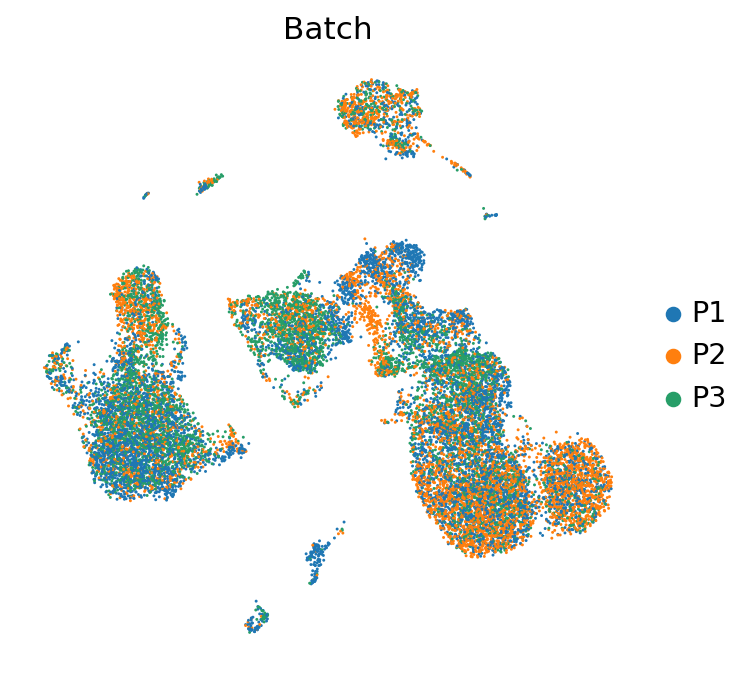

In [6]:
get_scvi_results(adata, layers=2)

А вот такие результаты выдает модель с 1 скрытым слоем

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.20s/it, loss=402, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it, loss=402, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


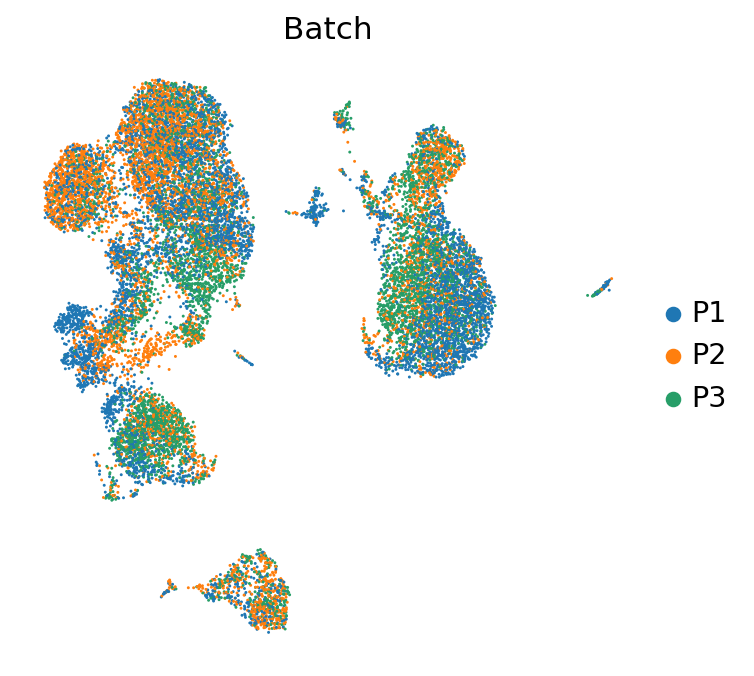

In [7]:
get_scvi_results(adata, layers=1)

В целом, получили примерно одинаковые результаты, что с моделью с одним скрытым слоем, что с двумя.

Отрисуем результаты модели с 10 скрытыми слоями



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [04:57<00:00,  2.89s/it, loss=413, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [04:57<00:00,  2.97s/it, loss=413, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


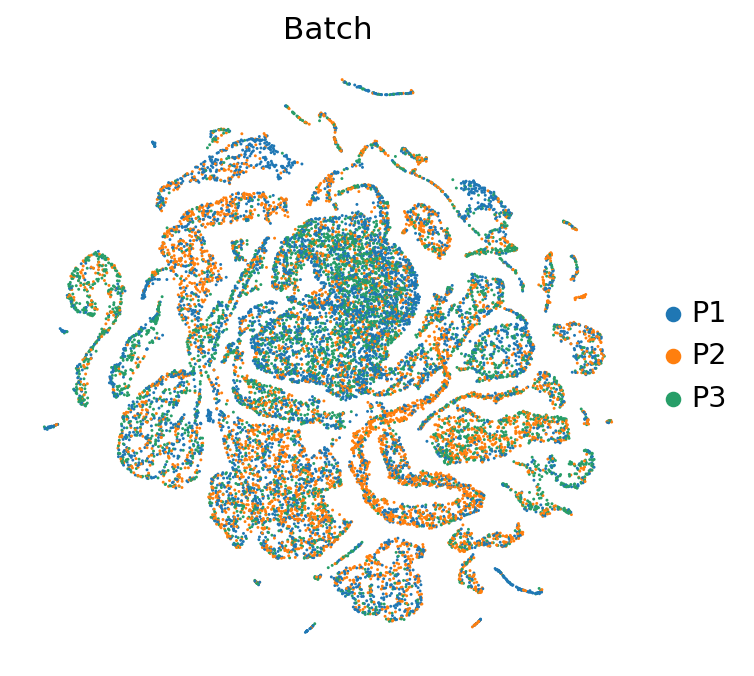

In [9]:
get_scvi_results(adata, layers=10)

Модель с одним скрытыми слоем дает вполне нормальный результат. При увеличении количества скрытых слоев не происходит повышению батч-коррекции, и результат с десятью скрытыми слоями получился, мягко говоря, не очень.

### Параметр n_hidden (количество нейронов в каждом скрытом слое)

Отрисуем модель с 8 нейронами в скрытом слое

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:15<00:00,  1.61s/it, loss=431, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:15<00:00,  1.35s/it, loss=431, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


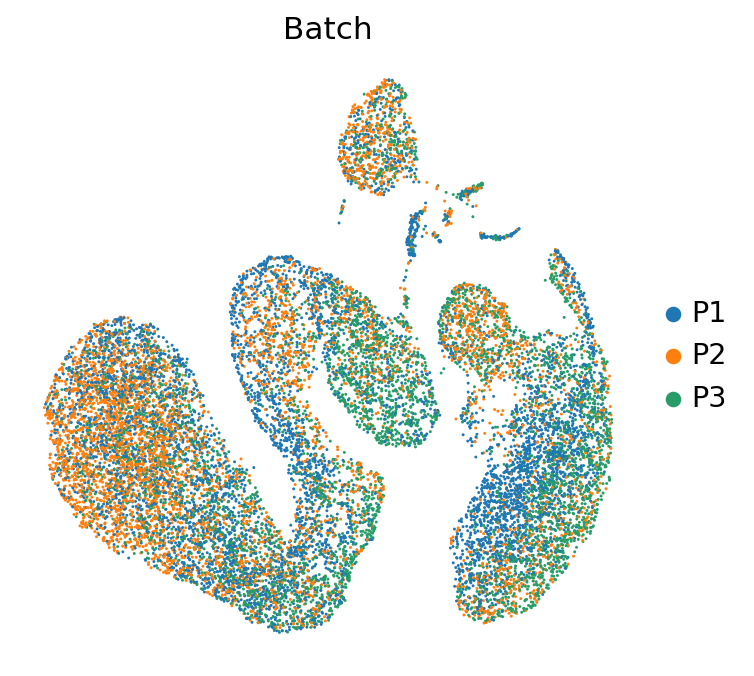

In [10]:
get_scvi_results(adata, hidden=8)

А теперь с 128 нейронами в скрытом слое

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.20s/it, loss=402, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it, loss=402, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


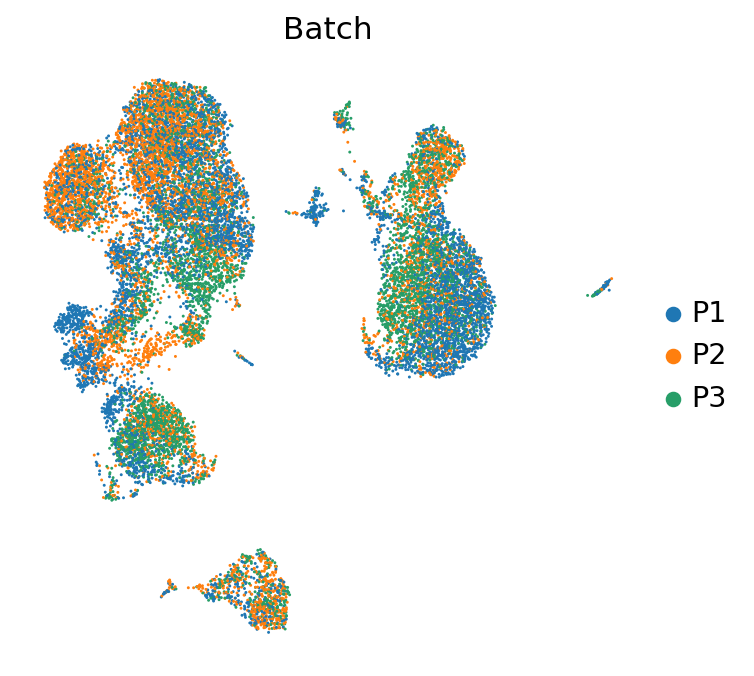

In [ ]:
get_scvi_results(adata, hidden=128)

Можно заметить, что низкое количество нейронов в скрытом слое приводит к плохим результатам. Попробуем значительно увеличить количество нейронов в скрытом слое.

С 512 нейронами в скрытом слое получаются такие результаты:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:12<00:00,  1.23s/it, loss=391, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:12<00:00,  1.32s/it, loss=391, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


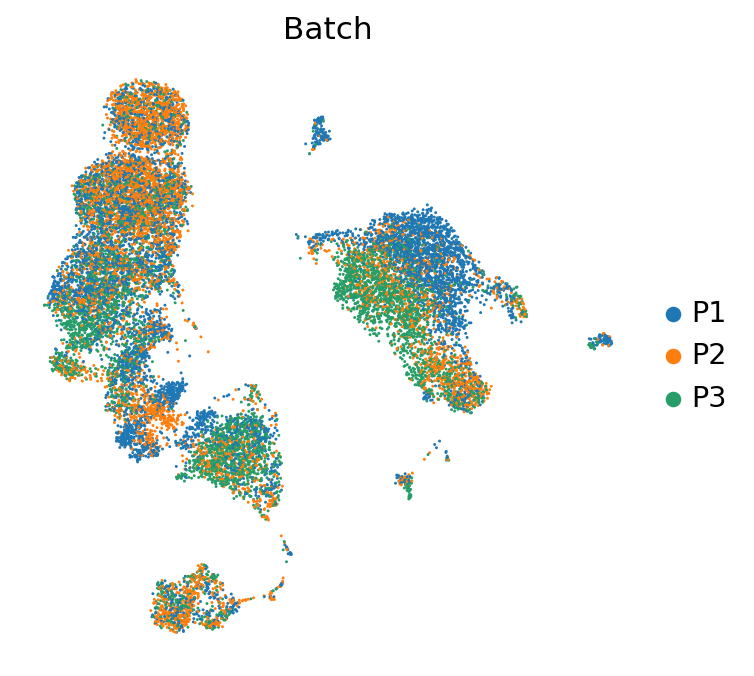

In [11]:
get_scvi_results(adata, hidden=512)

А вот значительное увеличение количество нейронов не привело к сильным изменениями результатов модели.

### Параметр n_latent (размерность скрытого пространства)

C 2-мерным скрытым пространством мы получаем следующие результаты:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:01<00:00,  1.20s/it, loss=418, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it, loss=418, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


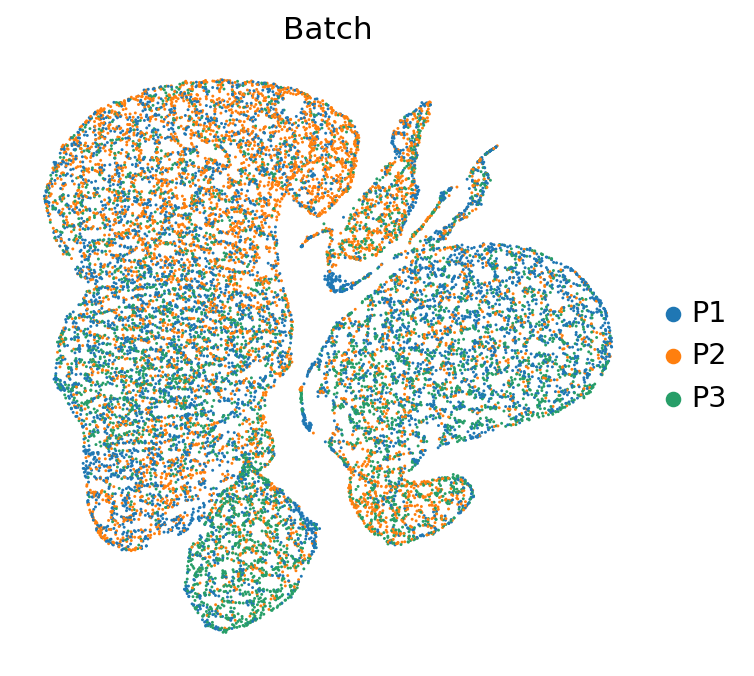

In [12]:
get_scvi_results(adata, latent=2)

А с 10-мерным:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.20s/it, loss=402, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it, loss=402, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


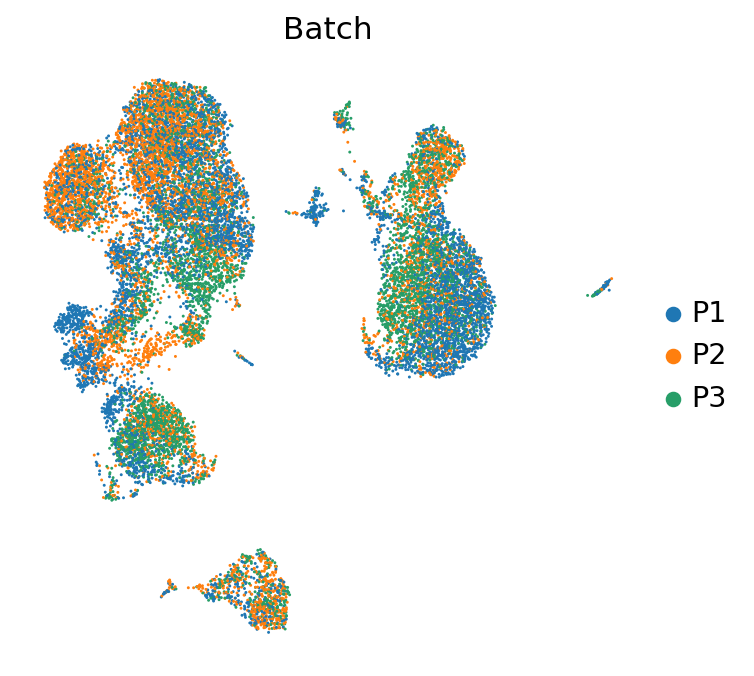

In [ ]:
get_scvi_results(adata, latent=10)

C 30-мерным скрытым пространством получаем следующее:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:04<00:00,  1.22s/it, loss=394, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it, loss=394, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


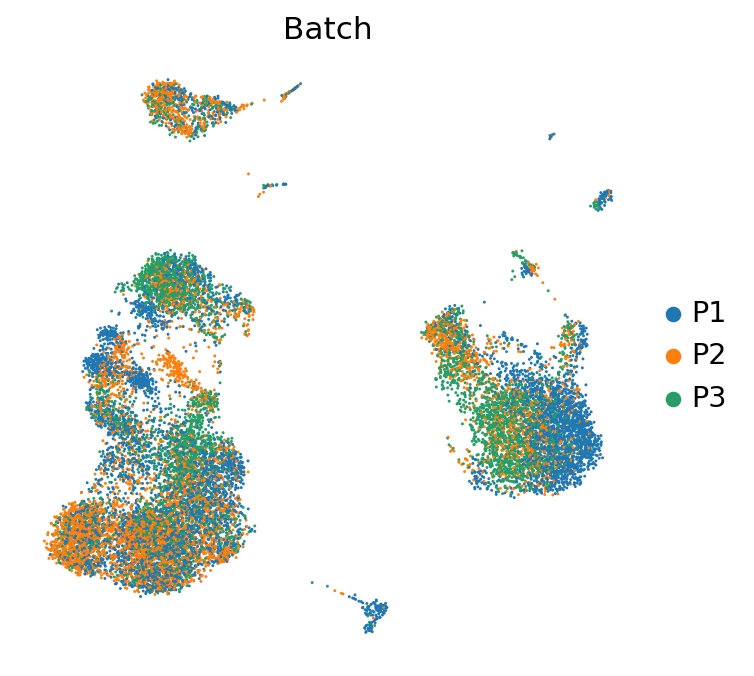

In [13]:
get_scvi_results(adata, latent=30)

### Параметр dropout_rate (порог отсева нейронов в нейронной сети)



Посмотрим на результат модели с дефолтным значением dropout_rate

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.20s/it, loss=402, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it, loss=402, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


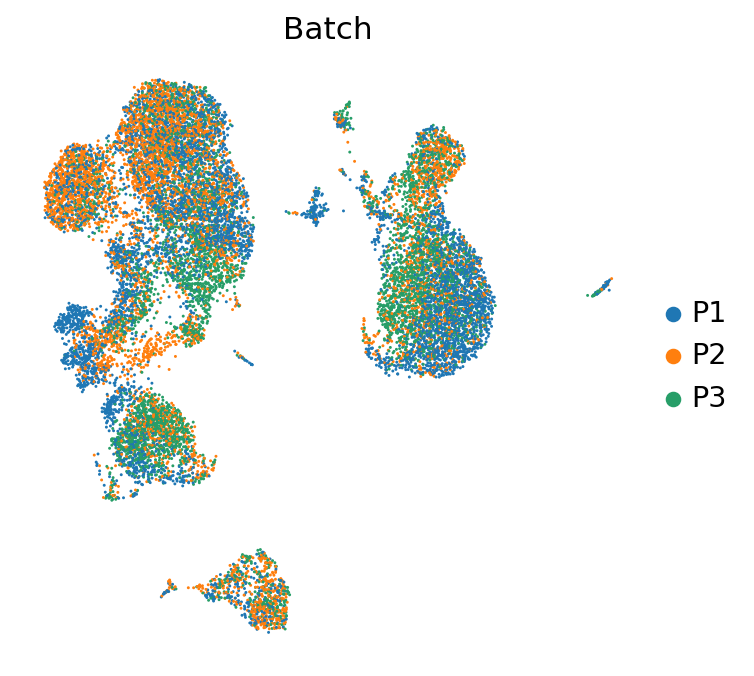

In [ ]:
get_scvi_results(adata, dropout_rate=0.01)

Значительно уменьшим dropout_rate и посмотрим, что получится:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:00<00:00,  1.23s/it, loss=399, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:00<00:00,  1.21s/it, loss=399, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


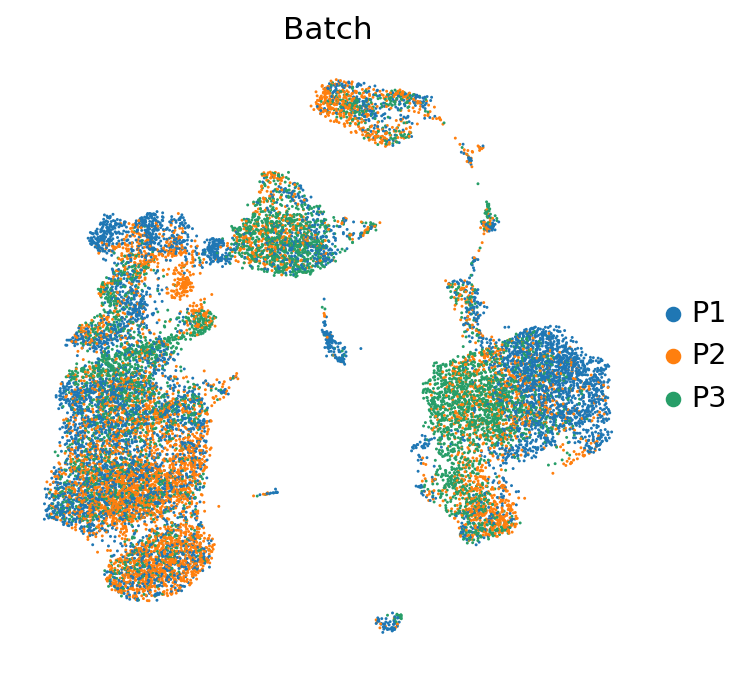

In [14]:
get_scvi_results(adata, dropout_rate=0.001)

А теперь значительно увеличим этот параметр и посмотрим, что будет:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.20s/it, loss=404, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it, loss=404, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


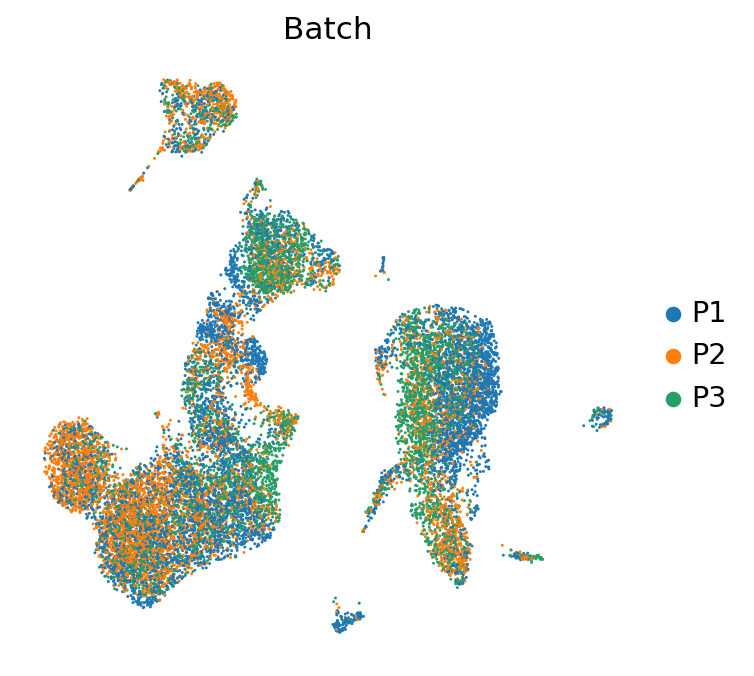

In [15]:
get_scvi_results(adata, dropout_rate=0.1)

При значительном уменьшении и увеличении данного параметра практически не изменяются результаты модели.

### Параметр dispersion (параметры NB-dist)

Установим дефолтный параметр дисперсии NB распределения

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.20s/it, loss=402, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it, loss=402, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


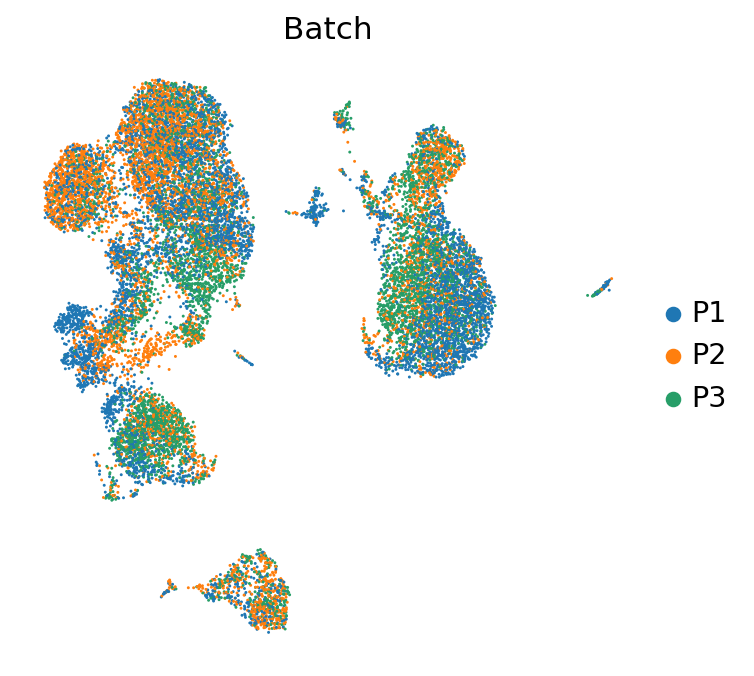

In [ ]:
get_scvi_results(adata, dispersion='gene')

Посмотрим результат модели с диперсией на уровне батчей

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:10<00:00,  1.21s/it, loss=400, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it, loss=400, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


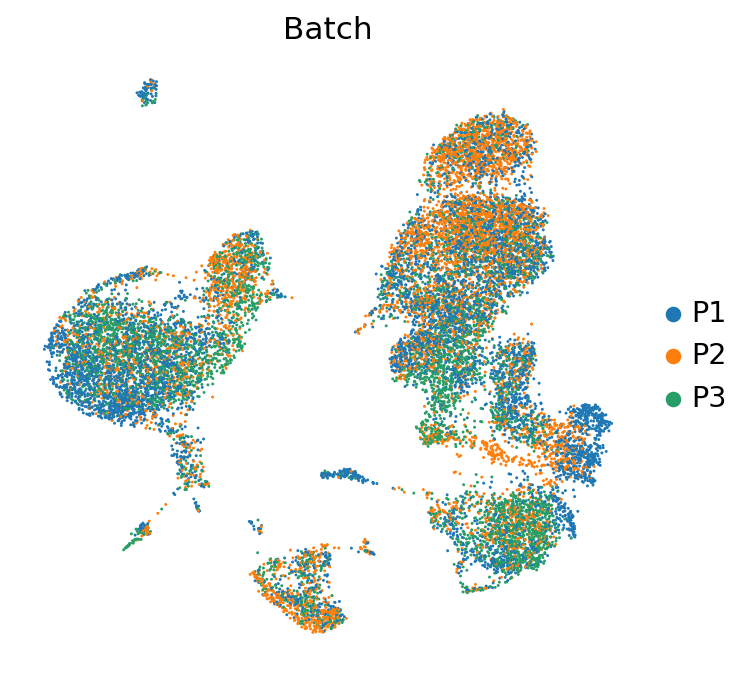

In [17]:
get_scvi_results(adata, dispersion='gene-batch')

А так выглядит результат модели с дисперсией на уровне генов

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:08<00:00,  1.25s/it, loss=401, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it, loss=401, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


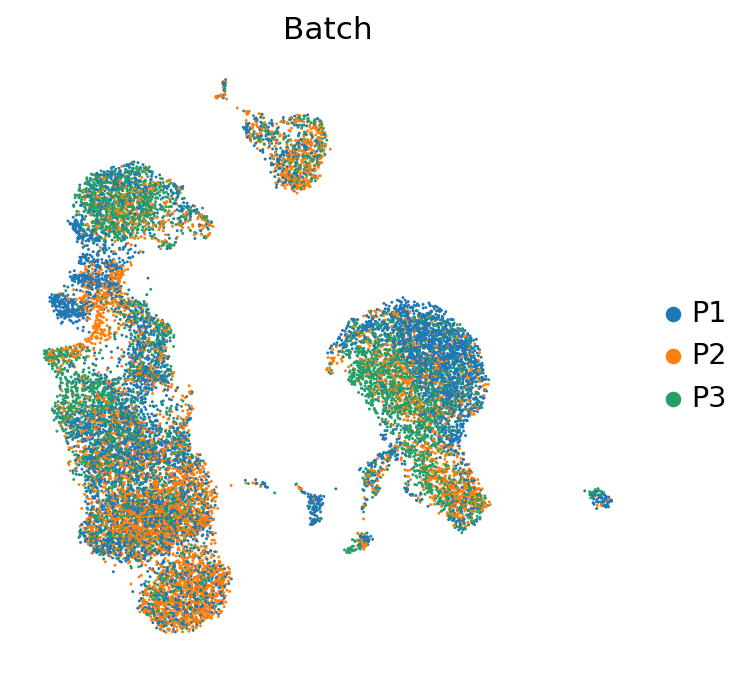

In [18]:
get_scvi_results(adata, dispersion='gene-label')

Параметр с дисперсией на уровне клеток

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:28<00:00,  1.28s/it, loss=398, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it, loss=398, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


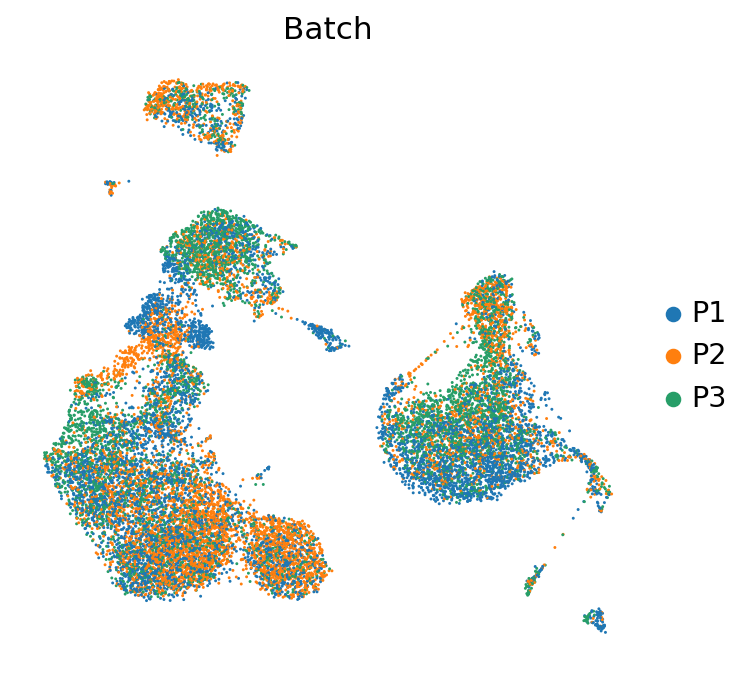

In [19]:
get_scvi_results(adata, dispersion='gene-cell')

Можно заметить, что изменение данного параметра не так сильно влияет на результат модели.

### Параметр gene_likelihood (тип распределения: NB, ZINB или Poisson)

Установим дефолтное ZINB распределение:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.20s/it, loss=402, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it, loss=402, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


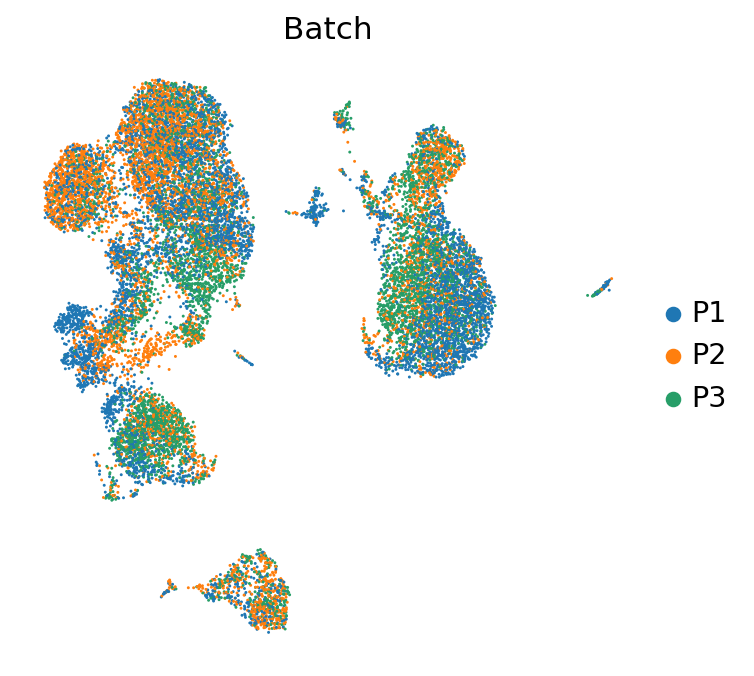

In [ ]:
get_scvi_results(adata, gene_likelihood='zinb')

Так выглядит результат с NB распределением:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:08<00:00,  1.15s/it, loss=401, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it, loss=401, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


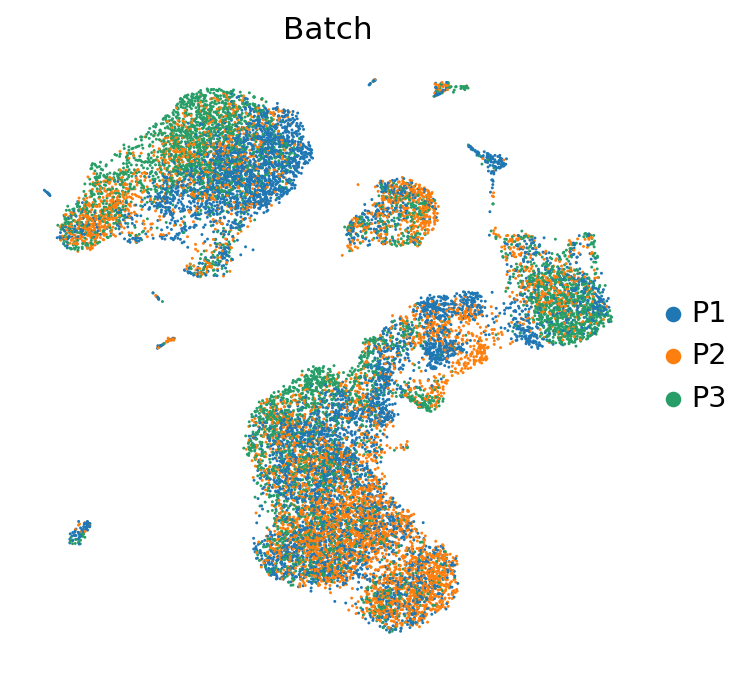

In [21]:
get_scvi_results(adata, gene_likelihood='nb')

А так с распределением Пуассона:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [01:53<00:00,  1.07s/it, loss=425, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it, loss=425, v_num=1]


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


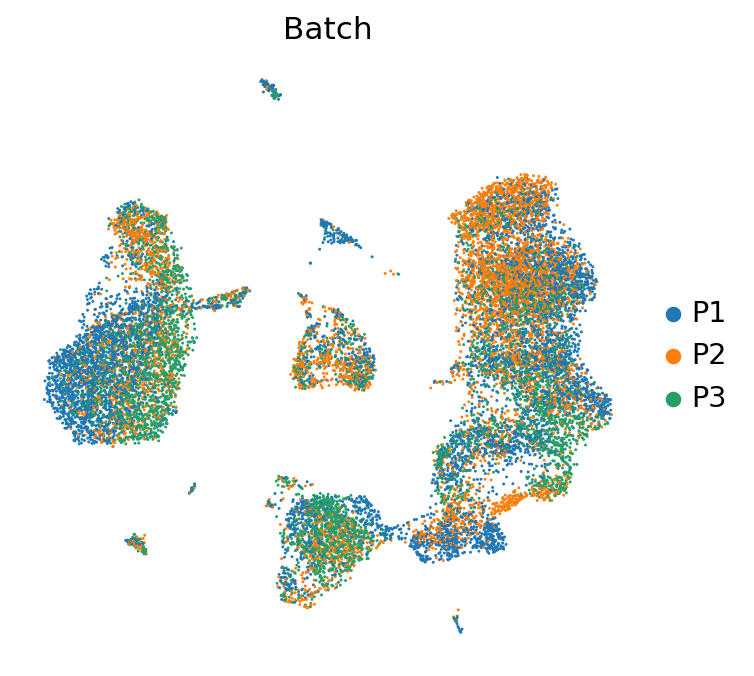

In [22]:
get_scvi_results(adata, gene_likelihood='poisson')

### Вывод

Можно выделить следующие параметры, значительно влияющие на результат модели:
* `n_layers` — количество скрытых слоёв (сильное увеличение скрытых слоев приводит к плохим результатам модели)
* `n_hidden` — количество нейронов в каждом скрытом слое (при очень низком количестве получается плохой результат)
* `n_latent` — размерность скрытого пространства (слишком низкая размерность пространства приводит к ухудшению качества модели и потере большей части биологической информации)

Все остальные параметры хоть и оказывают незначительный эффект на результат модели.


